### Labor Force Participation and Unemployment Rates In Times Of COVID-19 
                                    
By : Alex Ferrante & Vinicius Moreira

### 1. Introduction:

Within the United States, the COVID-19 pandemic created economic dismay and forced millions of individuals out of the labor force. Given that the virus was not restricted by geography, all regions of the U.S felt the economic instability. Throughout the pandemic, states revealed their preference for risk by either implementing more conservative mandates, or contrary, not implanting mandates at all. With the darkest days of COVID hopefully behind us, it is of great interest to understand how the implementation and extirpation of stimulus programs affected states economic recovery. 

In an effort to further investigate the severity in which COVID effected labor force participation, our project will first compare labor force participation rates at the regional and state-level during periods denoted as pre-COVID, intra-COVID, and post-COVID. By breaking the study into these three distinct time periods, it will be possible to interpret the direct effects COVID had on labor force participation. Next, we will test to detect if the announcement and expiration of Pandemic Unemployment Assistance (PUA) transfers from the Federal Government had an effect on labor force participation, and whether the date states made the annoncement had any significance. 

### 2. Pulling and Staging the Data

First, let's import the necessary packages to download the data, work with it, create plots, and run our analyses:

In [18]:
# FOR IMPORTING DATA
import requests
import json
import csv
import datetime

# FOR API
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from typing import List, Union, Optional

# FOR CHARTS
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib.colors as mplc
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

### 2.1 Pulling Data From Bureau of Labor Statistics (BLS)

Lets first set our API Key to be used for BLS, which is saved on a separate .txt file for security purposes

In [26]:
txt_file = open("BLS_API_KEY.txt")
apikey = txt_file.read()

Next, using the knowledge learned in class, we copy and adapt a function to download data from the BLS API:

In [27]:
def request_for_series(
        series_ids: List[str], 
        startyear: Union[int,str], 
        endyear: Union[int,str],
        apikey:Optional[str]=None,
    ):
    """
    Request data for all ``series_ids`` between ``startyear`` and ``endyear``
    
    Parameters
    ----------
    series_ids: List[str]
        A list of all BLS series IDs for which to request data
    
    startyear, endyear: Union[int,str]
        Starting and ending years for period of data. All intervals between
        these two years (inclusive) will be reported
    
    apikey: Optional[str]
        A registration or API key to enable more extensive use of the
        api and more detailed results
    
    Returns
    -------
    responses: List[requests.Response]
        A list of `Response` objects from the requests library
    
    Notes
    -----
    The BLS API only allows 25 series to be requested in a single call to the API
    This function allows an arbitrary number of series. The function first checks how 
    many series_ids are requested, and then makes two recursive calls to this function:
    
    (1) the first 25 series IDs are fetched and 
    (2) the rest of the series ids. 
    
    If the second request contains more than 25 series, another split is made and a pair of 
    recursive function calls are issued.
    
    Also note that the response objects from ``requests`` are not processed or validated
    in any way -- this is up to the caller of this routine.
    
    Finally, if an apikey is given, then a catalog of series metadata will be requested
    and returned from this function. This is necessary for getting the metadata DataFrame
    from the functions ``make_dfs_from_series``, ``unpack_response``, and 
    ``unpack_all_responses`` functions below.
    """
    n_series = len(series_ids)
    if n_series > 25:  #for more than 25, you work on this
        parts = []
        # make common keyword arguments so we don't have to type twice below
        kw = dict(endyear=endyear, startyear=startyear, apikey=apikey)
        parts.extend(request_for_series(series_ids[:25], **kw))
        parts.extend(request_for_series(series_ids[25:], **kw))
        return parts
    else:
        headers = {'Content-type': 'application/json'}
        params = {
            "seriesid": series_ids, 
            "startyear":startyear, 
            "endyear": endyear,
        }
        if apikey is not None:
            params["catalog"] = True
            params["registrationkey"] = apikey
        
        # convert params dictionary to json string
        data = json.dumps(params)
        p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
        return [p]

The function below is used to validate the search through the website (i.e. to see if it works):

In [28]:
def check_response(res: requests.Response):
    """
    Check a response from the BLS API for success
    
    Parameters
    ----------
    res: requests.Response
        The requests object returned from iteracting with BLS API
        
    Notes
    -----
    Right now we just check for success at the http protocol level
    and don't do any checking specific to the BLS api
    """
    code = res.status_code
    if code > 299:
        raise ValueError(f"Response error with code {code}")

This function is to transfer the data into dataframes:

In [29]:
def make_dfs_from_series(series_results):
    """
    Unpack a series response object into data and metadata pandas objects
    
    Parameters
    ----------
    series_results: dict
        A dictionary returned from the `timeseries/data` endpoint of the
        BLS api. An example object for this parameter would be found at
        ``res.json()["Results"]["series"][0]`` where ``res`` is the 
        ``requests.Response`` obtained from interacting with the API endpoint.
    
    Returns
    -------
    data: pd.DataFrame
        A pandas DataFrame containing the actual observations of the data series
    
    metadata: Optional[pd.Series]
        If the ``"catgalog"`` key exists in ``series_results``, then ``metadata``
        is a pandas Series containing the catalog information. If ``"catalog"``
        is found, then this is None    
    """
    #extract series ID and store as a variable
    series_id = series_results["seriesID"]
    
    #next, we create a panda dataframe, reading a list of dict
    #we attach ID as an additional column
    data = pd.DataFrame(series_results["data"]).assign(series_id=series_id)
    
    #if catalog was attached, we create a series
    #if not, we don't
    if "catalog" in series_results:
        metadata = pd.Series(series_results["catalog"])
    else:
        metadata = None
    
    return data, metadata

These two functions will unpack the data:

In [30]:
def unpack_response(res: requests.Response):
    """
    Unpack the response for requesting one or more timeseries 
    from the BLS api
    
    Parameters
    ----------
    res: requests.Response
        The object returned from interacting with the ``timeseries/data``
        BLS API endpoint via the reuqests library
    
    Returns
    -------
    datasets: List[Tuple[pd.DataFrame, pd.Series]]
        For each BLS series contained in ``res``, a tuple with the 
        timeseries observations and series metadata will be returned.
        The observations are a pandas DataFrame and the metadata is a
        pandas Series. These pairs of (data, metadata) are returned
        in a list
    
    See Also
    --------
    See ``make_dfs_from_series`` for more information on content
    of output.
    """
    #compute the json form of our response
    js = res.json()
    #now we map the results and series as above when we created data and meta
    
    return list(map(make_dfs_from_series, js["Results"]["series"]))


def unpack_all_responses(all_res: List[requests.Response]):
    """
    Given a list of responses from the BLS API, extract and 
    return all data and metadata
    
    Parameters
    ----------
    all_res: List[requests.Response])
        Each item in this list is the result of using ``requests`` to 
        fetch data from ``timeseries/data`` endpoint of the BLS API.
        
    Returns
    -------
    data: pd.DataFrame
        A pandas DataFrame containing all timeseries observations included
        in any of the responses in ``all_res``
    
    metadata: pd.DataFrame
        Detailed metadata about each series, if such metadata exists in the
        response objects
    
    See Also
    --------
    See ``unpack_response`` and ``make_dfs_from_series`` functions
        
    """
    #make unpacked an empty list
    unpacked = []
    
    #then use a for function to unpack all of them (list)
    for res in all_res:
        unpacked.extend(unpack_response(res))
    
    data_dfs, metadata_series = list(zip(*unpacked))
    
    #stack all data one on the top of the other
    data = pd.concat(data_dfs, ignore_index=True)
    
    #add the metadata and stack them as columns
    metadata = pd.concat([x for x in metadata_series if x is not None], axis=1).T
    
    return data, metadata

Now, let's find all the series of interest.

If it ends with:

3. Seasonally adjustment unemployment rate. 
4. Seasonally adjusted unemployment level
5. Seasonally adjusted employment level
6. Seasonally adjusted labor force level
7. Seasonally adjusted employment-population ratio
8. Seasonally adjusted labor force participation ratio

We will use only 3 and 8 in our analysis. The first two numbers refer to the state from which the data is extracted.

Source: https://www.bls.gov/lau/

In [31]:
series_ids = [
    "LASST010000000000003", 
    "LASST010000000000008", 
    "LASST020000000000003", 
    "LASST020000000000008", 
    "LASST030000000000003",
    "LASST030000000000008", 
    "LASST040000000000003",
    "LASST040000000000008", 
    "LASST050000000000003", 
    "LASST050000000000008", 
    "LASST060000000000003", 
    "LASST060000000000008", 
    "LASST070000000000003", 
    "LASST070000000000008", 
    "LASST080000000000003", 
    "LASST080000000000008", 
    "LASST090000000000003",
    "LASST090000000000008", 
    "LASST100000000000003",
    "LASST100000000000008", 
    "LASST110000000000003", 
    "LASST110000000000008", 
    "LASST120000000000003", 
    "LASST120000000000008", 
    "LASST130000000000003", 
    "LASST130000000000008", 
    "LASST140000000000003", 
    "LASST140000000000008", 
    "LASST150000000000003", 
    "LASST150000000000008", 
    "LASST160000000000003", 
    "LASST160000000000008", 
    "LASST170000000000003", 
    "LASST170000000000008", 
    "LASST180000000000003", 
    "LASST180000000000008", 
    "LASST190000000000003", 
    "LASST190000000000008",
    "LASST200000000000003", 
    "LASST200000000000008", 
    "LASST210000000000003", 
    "LASST210000000000008", 
    "LASST220000000000003", 
    "LASST220000000000008", 
    "LASST230000000000003", 
    "LASST230000000000008", 
    "LASST240000000000003", 
    "LASST240000000000008", 
    "LASST250000000000003", 
    "LASST250000000000008", 
    "LASST260000000000003", 
    "LASST260000000000008", 
    "LASST270000000000003", 
    "LASST270000000000008", 
    "LASST280000000000003", 
    "LASST280000000000008", 
    "LASST290000000000003", 
    "LASST290000000000008", 
    "LASST300000000000003", 
    "LASST300000000000008", 
    "LASST310000000000003",
    "LASST310000000000008", 
    "LASST320000000000003", 
    "LASST320000000000008", 
    "LASST330000000000003", 
    "LASST330000000000008",
    "LASST340000000000003", 
    "LASST340000000000008", 
    "LASST350000000000003",
    "LASST350000000000008",  
    "LASST360000000000003", 
    "LASST360000000000008", 
    "LASST370000000000003", 
    "LASST380000000000008", 
    "LASST370000000000003", 
    "LASST380000000000008", 
    "LASST370000000000003", 
    "LASST380000000000008", 
    "LASST390000000000003", 
    "LASST390000000000008",    
    "LASST400000000000003", 
    "LASST400000000000008", 
    "LASST410000000000003", 
    "LASST410000000000008", 
    "LASST420000000000003", 
    "LASST420000000000008", 
    "LASST430000000000003", 
    "LASST430000000000008", 
    "LASST440000000000003", 
    "LASST440000000000008", 
    "LASST450000000000003", 
    "LASST450000000000008", 
    "LASST460000000000003", 
    "LASST460000000000008", 
    "LASST470000000000003", 
    "LASST470000000000008", 
    "LASST480000000000003", 
    "LASST480000000000008", 
    "LASST490000000000003", 
    "LASST490000000000008", 
    "LASST500000000000003", 
    "LASST500000000000008",
    "LASST510000000000003", 
    "LASST510000000000008",
    "LASST520000000000003",
    "LASST520000000000008",
    "LASST530000000000003", 
    "LASST530000000000008", 
    "LASST540000000000003", 
    "LASST540000000000008",     
    "LASST550000000000003", 
    "LASST550000000000008", 
    "LASST560000000000003", 
    "LASST560000000000008",
]

# make requests, get responses
responses1 = request_for_series(series_ids, "1976", "1995", apikey=apikey)

# validate the responses
[check_response(r) for r in responses1]

# extract data and metadata from responses
df1, metadata1 = unpack_all_responses(responses1)

# pull data for date range: 1996 - 2015
responses2 = request_for_series(series_ids, "1996", "2015", apikey=apikey)
df2, metadata2 = unpack_all_responses(responses2)

# pull data for date range: 2016 - 2021
responses3 = request_for_series(series_ids, "2016", "2021", apikey=apikey)
df3, metadata3 = unpack_all_responses(responses3)

### 2.2 Incorporating Data Related to State PUA

Since one of the objectives of this project is to understand whether the announcement date and exipiration date of PUA payments effects the rate at which indivudals rejoined the labor force, 

we will now incorporate data on the dates when states announced (announce_ui) that PUA will expire in additon to the actual date when PUA expired (expired_ui). 

In [32]:
announce_url = "https://raw.githubusercontent.com/vgm236/ferrante_moreira_data_project/main/Data/announced_dates_ui_expiration.csv"
announce_ui = pd.read_csv(announce_url)

expired_url = "https://raw.githubusercontent.com/vgm236/ferrante_moreira_data_project/main/Data/effective_dates_ui_expiration.csv"
expired_ui = pd.read_csv(expired_url)

### 3. Preparing Data for Analysis 

Since the data for state unemployment rate and labor force participation was pulled in three groups (1976-1995, 1996-2015, 2016-2021), we will now combine to create one dataframe for unemployment and 

labor force participation values and one for metadata

In [33]:
# create single dataframe for df1, df2, and df3
df = pd.concat([df1, df2, df3])

df = df.sort_values(by=["year"]) 

df["year"].unique()

array(['1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991',
       '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',
       '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019', '2020', '2021'], dtype=object)

In [34]:
# create single dataframe for metadata1, metadata2, metadata3
metadata = pd.concat([metadata1, metadata2, metadata3])

Since the Metadata dataframe is composed of both unemployment rate and labor force participation, we will separate accordingly 

In [35]:
# Dataframe including only measure data types for unemployment rate
df_ur = metadata.query("measure_data_type == 'unemployment rate'")

# Dataframe including only measure data types for labor force participation
df_lfp = metadata.query("measure_data_type == 'labor force participation rate'")

Now that we have the dataframes seperated by unemployment rate and labor force participation, we can map values from the df 

dataframe to the df_ur and df_lfp dataframes using series_ids

In [36]:
# Merge df on df_ur by series id to get each states unemployment rate
df_ur_values = df_ur.merge(df, on="series_id", how="left")

In [37]:
# Merge df on df_lfp by series id to get each states labor force participation rate
df_lfp_values = df_lfp.merge(df, on="series_id", how="left")

In [38]:
# merge unemployment announcement date and expiration date to single dataframe 
ui_dates = announce_ui.merge(expired_ui, on="state_abrev", how="left")

# change to datetime 
ui_dates["effe_date"] = pd.to_datetime(ui_dates["effe_date"])
ui_dates["annc_date"] = pd.to_datetime(ui_dates["annc_date"])

# change state_abrev to area for future merging simplicity
state = {"state_abrev" : "area"}
ui_dates = ui_dates.rename(columns=state)

In [39]:
# change "area" values to abbrevations to allow for merging ui_dates  
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY"
}

df_ur_values["area"] = df_ur_values["area"].replace(us_state_to_abbrev)

df_lfp_values["area"] = df_lfp_values["area"].replace(us_state_to_abbrev)

In [41]:
# Data Preparation for analyses
pd.options.mode.chained_assignment = None
# Create smaller DataFrames for UR and LFP with only necessary columns
df_ur_small = df_ur_values[["area", "year", "period", "value"]]
df_lfp_small = df_lfp_values[["area", "year", "period", "value"]]

# Remove the M from period to create an integer for the month, then create a new column which is the date (Year-Month-Day)
df_ur_small["month"] = df_ur_small["period"].str.strip("M").astype(int) 
df_ur_small["date"] = pd.to_datetime(df_ur_small[["year", "month"]].assign(DAY=1))

df_lfp_small["month"] = df_lfp_small["period"].str.strip("M").astype(int)
df_lfp_small["date"] = pd.to_datetime(df_lfp_small[["year", "month"]].assign(DAY=1))

# Re-label values in both DataFrames so it is clear which refers to UR and LFP once merged
ur_value_name = {"value" : "unemployment_rate"}
lfp_value_name = {"value" : "labor_force_participation"}

df_ur_small = df_ur_small.rename(columns=ur_value_name)
df_lfp_small = df_lfp_small.rename(columns=lfp_value_name)

# Drop uncessary columns
df_ur_small = df_ur_small[["area", "unemployment_rate", "date"]]
df_lfp_small = df_lfp_small[["area", "labor_force_participation", "date"]]

# Merge the two Dataframe on area and year
df_ur_lfp = df_ur_small.merge(
    df_lfp_small, how='left', 
    left_on=['area', 'date'], 
    right_on=['area', 'date']
    ).drop_duplicates(subset=["area", "date"])

# Turn UR and LFP values to float 
df_ur_lfp["unemployment_rate"] = df_ur_lfp["unemployment_rate"].astype(float)
df_ur_lfp["labor_force_participation"] = df_ur_lfp["labor_force_participation"].astype(float)

# Reshape data for analyses
df_ur_lfp = df_ur_lfp.pivot(
    index="date", 
    columns="area", 
    values=["unemployment_rate", "labor_force_participation"])

### 4. Compare and Contrast State-level Unemployment Rates and Labor Force Participation for Pre, Intra, and Post COVID 

In order to compare how State's labor force participation has changed over time, we will need to construct three dataframes for three seperate periods of time. The first subset of data will be for the time 

period of 2015 - 2019 (denoted as pre-COVID). This pre-COVID period with relative econoimc stability will allow for a clear contrast in interpreting the impact COVID had on state-level unemplloyment rates 

and labor force participation. The next period will be January 1, 2020 - January 31, 2020 (denoted as Intra-COVID), and the third period will be January 1st, 2021 to present (denoted as post-COVID). 

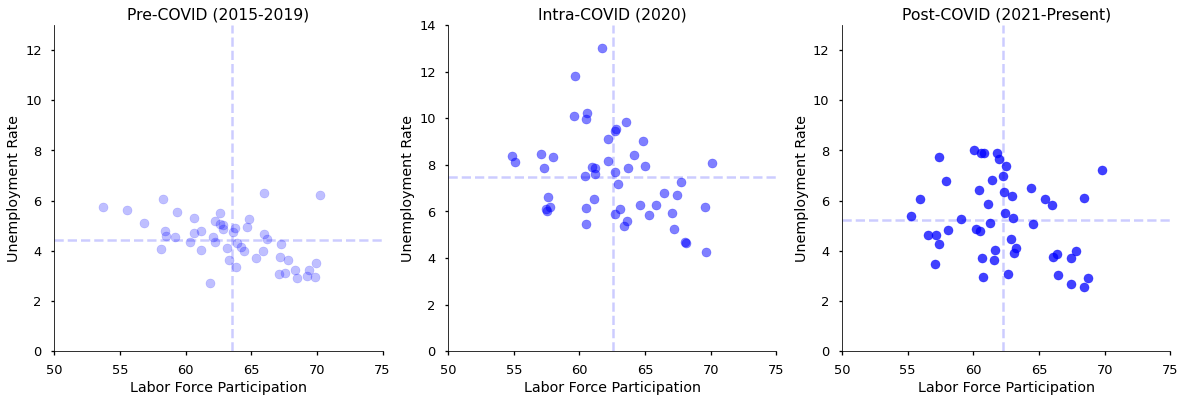

In [113]:
# Generate three datasets for three periods of interest (pre, intra, and post COVID)
df_pre_covid = df_ur_lfp["2015-01-01":"2019-01-01"]

df_intra_covid = df_ur_lfp["2020-01-01":"2020-12-31"]

df_post_covid = df_ur_lfp["2021-01-01":"2021-10-31"]


fig, ax = plt.subplots(1, 3, figsize=(20, 6))

ax[0].scatter(
    df_pre_covid["labor_force_participation"].mean(), 
    df_pre_covid["unemployment_rate"].mean(), color='b', alpha=0.25)
ax[0].set_title("Pre-COVID (2015-2019)")
ax[0].set_xlim(50, 75)
ax[0].set_ylim(0, 13)
ax[0].axvline(
    np.mean(df_pre_covid["labor_force_participation"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha=0.2)
ax[0].axhline(
    np.mean(df_pre_covid["unemployment_rate"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha = 0.2)

ax[1].scatter(
    df_intra_covid["labor_force_participation"].mean(), 
    df_intra_covid["unemployment_rate"].mean(), color='b', alpha=0.5)
ax[1].set_title("Intra-COVID (2020)")
ax[1].set_xlim(50, 75)
ax[1].set_ylim(0, 14)
ax[1].axvline(
    np.mean(df_intra_covid["labor_force_participation"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha=0.2)
ax[1].axhline(
    np.mean(df_intra_covid["unemployment_rate"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha = 0.2)

ax[2].scatter(
    df_post_covid["labor_force_participation"].mean(), 
    df_post_covid["unemployment_rate"].mean(), color='b', alpha=0.75)
ax[2].set_title("Post-COVID (2021-Present)")
ax[2].set_xlim(50, 75)
ax[2].set_ylim(0, 13)
ax[2].axvline(
    np.mean(df_post_covid["labor_force_participation"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha=0.2)
ax[2].axhline(
    np.mean(df_post_covid["unemployment_rate"].mean()), 
    color='b', ls='--', 
    lw=2.5, 
    alpha = 0.2)

for i in [0, 1, 2]:
    ax[i].set_ylabel("Unemployment Rate")
    ax[i].set_xlabel("Labor Force Participation")

for i in [0, 1, 2]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

plt.style.use("seaborn-talk")

In [43]:
ur_titles = ["pre-COVID UR:", "intra-COVID UR:", "post-COVID UR:"]
ur_sets = [df_pre_covid, df_intra_covid, df_post_covid]

for (i, j) in zip(ur_titles, ur_sets):
    print(i, np.mean(j["unemployment_rate"].mean()).round(2),"%")

lfp_titles = ["pre-COVID LFP:", "intra-COVID LFP:", "post-COVID LFP:"]
lfp_sets = [df_pre_covid, df_intra_covid, df_post_covid]

for (i, j) in zip(lfp_titles, lfp_sets):
    print(i, np.mean(j["labor_force_participation"].mean()).round(2),"%")

pre-COVID UR: 4.42 %
intra-COVID UR: 7.46 %
post-COVID UR: 5.24 %
pre-COVID LFP: 63.53 %
intra-COVID LFP: 62.59 %
post-COVID LFP: 62.27 %


The plots above display annual, state-level mean values for labor force participation and unemployment rate. Moving from left to right, we can observe the state's transitions over time, where as expected, 

the Intra-COVID period witnessed a 3.04% mean increase in unemployment rate and 0.93% mean decrease in labor force participation. More interestingly, the movement from intra-COVID to post-COVID reveals

that unemployment rate fell by 2.22% and labor force participation decreased by 0.32%. While a marginal portion of the decrease in unemployment can be explained by those leaving the labor force, the 

phenomenon to focus on is the notion that indivduals during this period continued to leave the labor force amidst improving COVID conditions. Additionally, you can see that in in the pre-COVID era, states

were in a relatively tight cluster, however, as time progresses we notice that the dispersion of the points increases, where now it is now more common for states to have varying levels of unemployment and 

labor force participation.

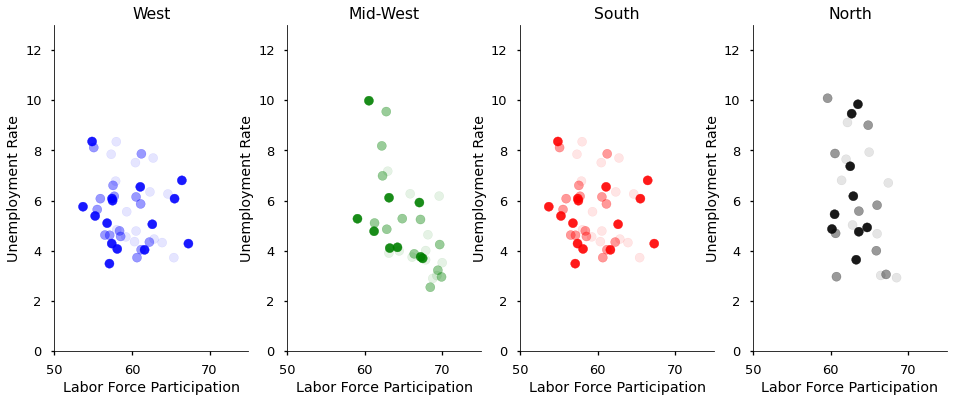

In [230]:
# Pre, intra, and post COVID unemployment rate and labor force participation for Western U.S
pre_west_ur = df_pre_covid["unemployment_rate"][["WA", "OR", "CA", "ID", "MT", "WY", 
                                                 "NV", "UT", "CO", "AZ", "NM"]]
pre_west_lfp = df_pre_covid["labor_force_participation"][["WA", "OR", "CA", "ID", "MT", "WY", 
                                                         "NV", "UT", "CO", "AZ", "NM"]]
intra_west_ur = df_intra_covid["unemployment_rate"][["WA", "OR", "CA", "ID", "MT", "WY", 
                                                 "NV", "UT", "CO", "AZ", "NM"]]
intra_west_lfp = df_intra_covid["labor_force_participation"][["WA", "OR", "CA", "ID", "MT", "WY", 
                                                         "NV", "UT", "CO", "AZ", "NM"]]
post_west_ur = df_post_covid["unemployment_rate"][["WA", "OR", "CA", "ID", "MT", "WY", 
                                                 "NV", "UT", "CO", "AZ", "NM"]]
post_west_lfp = df_post_covid["labor_force_participation"][["WA", "OR", "CA", "ID", "MT", "WY", 
                                                         "NV", "UT", "CO", "AZ", "NM"]]

# Pre, intra, and post COVID unemployment rate and labor force participation for Mid-Western U.S
pre_mid_ur = df_pre_covid["unemployment_rate"][["SD", "NE", "KS", "MN", "IA", 
                                                "MO", "WI", "IL", "MI", "IN", "OH"]]
pre_mid_lfp = df_pre_covid["labor_force_participation"][["SD", "NE", "KS", "MN", "IA", 
                                                        "MO", "WI", "IL", "MI", "IN", "OH"]]
intra_mid_ur = df_intra_covid["unemployment_rate"][["SD", "NE", "KS", "MN", "IA", 
                                                "MO", "WI", "IL", "MI", "IN", "OH"]]
intra_mid_lfp = df_intra_covid["labor_force_participation"][["SD", "NE", "KS", "MN", "IA", 
                                                        "MO", "WI", "IL", "MI", "IN", "OH"]]
post_mid_ur = df_post_covid["unemployment_rate"][["SD", "NE", "KS", "MN", "IA", 
                                                "MO", "WI", "IL", "MI", "IN", "OH"]]
post_mid_lfp = df_post_covid["labor_force_participation"][["SD", "NE", "KS", "MN", "IA", 
                                                        "MO", "WI", "IL", "MI", "IN", "OH"]]

# Pre, intra, and post COVID unemployment rate and labor force participation for Northern U.S
pre_north_ur = df_pre_covid["unemployment_rate"][["PA", "NY", "NJ", "CT", 
                                                  "MA", "RI", "NH", "VT", "ME"]]
pre_north_lfp = df_pre_covid["labor_force_participation"][["PA", "NY", "NJ", "CT", 
                                                           "MA", "RI", "NH", "VT", "ME"]]
intra_north_ur = df_intra_covid["unemployment_rate"][["PA", "NY", "NJ", "CT", 
                                                  "MA", "RI", "NH", "VT", "ME"]]
intra_north_lfp = df_intra_covid["labor_force_participation"][["PA", "NY", "NJ", "CT", 
                                                           "MA", "RI", "NH", "VT", "ME"]]
post_north_ur = df_post_covid["unemployment_rate"][["PA", "NY", "NJ", "CT", 
                                                  "MA", "RI", "NH", "VT", "ME"]]
post_north_lfp = df_post_covid["labor_force_participation"][["PA", "NY", "NJ", "CT", 
                                                           "MA", "RI", "NH", "VT", "ME"]]

# Pre, intra, and post COVID unemployment rate and labor force participation for Southern U.S
pre_south_ur = df_pre_covid["unemployment_rate"][["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", 
                                                  "WV", "VA", "DE", "MD", "NC", "SC", "GA", "FL"]]
pre_south_lfp = df_pre_covid["labor_force_participation"][["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", 
                                                           "WV", "VA", "DE", "MD", "NC", "SC", "GA", "FL"]]
intra_south_ur = df_intra_covid["unemployment_rate"][["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", 
                                                  "WV", "VA", "DE", "MD", "NC", "SC", "GA", "FL"]]
intra_south_lfp = df_intra_covid["labor_force_participation"][["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", 
                                                           "WV", "VA", "DE", "MD", "NC", "SC", "GA", "FL"]]
post_south_ur = df_post_covid["unemployment_rate"][["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", 
                                                  "WV", "VA", "DE", "MD", "NC", "SC", "GA", "FL"]]
post_south_lfp = df_post_covid["labor_force_participation"][["TX", "OK", "AR", "LA", "MS", "AL", "TN", "KY", 
                                                           "WV", "VA", "DE", "MD", "NC", "SC", "GA", "FL"]]


# Scatter plots showing transitions through pre, intra, and post COVID by region 
fig, ax = plt.subplots(1,4, figsize=(16,6))

west_ur = [pre_west_ur, intra_west_ur, post_west_ur]
west_lfp = [pre_west_lfp, intra_west_lfp, post_west_lfp]

for (j, i) in zip(south_ur, south_lfp):
    ax[0].scatter(
        i.mean(),
        j.mean(),
        color='b',
        alpha=[0.1, 0.4, 0.9])

mid_ur = [pre_mid_ur, intra_mid_ur, post_mid_ur]
mid_lfp = [pre_mid_lfp, intra_mid_lfp, post_mid_lfp]

for (j, i) in zip(mid_ur, mid_lfp):
    ax[1].scatter(
        i.mean(),
        j.mean(),
        color='g',
        alpha=[0.1, 0.4, 0.9]
    )

south_ur = [pre_south_ur, intra_south_ur, post_south_ur]
south_lfp = [pre_south_lfp, intra_south_lfp, post_south_lfp]

for (j, i) in zip(south_ur, south_lfp):
    ax[2].scatter(
        i.mean(),
        j.mean(),
        color='r',
        alpha=[0.1, 0.4, 0.9]
    )

north_ur = [pre_north_ur, intra_north_ur, post_north_ur]
north_lfp = [pre_north_lfp, intra_north_lfp, post_north_lfp]

for (j, i) in zip(north_ur, north_lfp):
    ax[3].scatter(
        i.mean(),
        j.mean(),
        color='black',
        alpha=[0.1, 0.4, 0.9]
    )

for i in [0, 1, 2, 3]:
    ax[i].set_xlim(50, 75),
    ax[i].set_ylim(0, 13)

region_titles = ["West", "Mid-West", "South", "North"]
count = [0, 1, 2, 3]

for (i, j) in zip(count, region_titles):
    ax[i].set_title(j)

for i in [0, 1, 2, 3]:
    ax[i].set_ylabel("Unemployment Rate")
    ax[i].set_xlabel("Labor Force Participation")

for i in [0, 1, 2, 3]:
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)

plt.style.use("seaborn-talk")

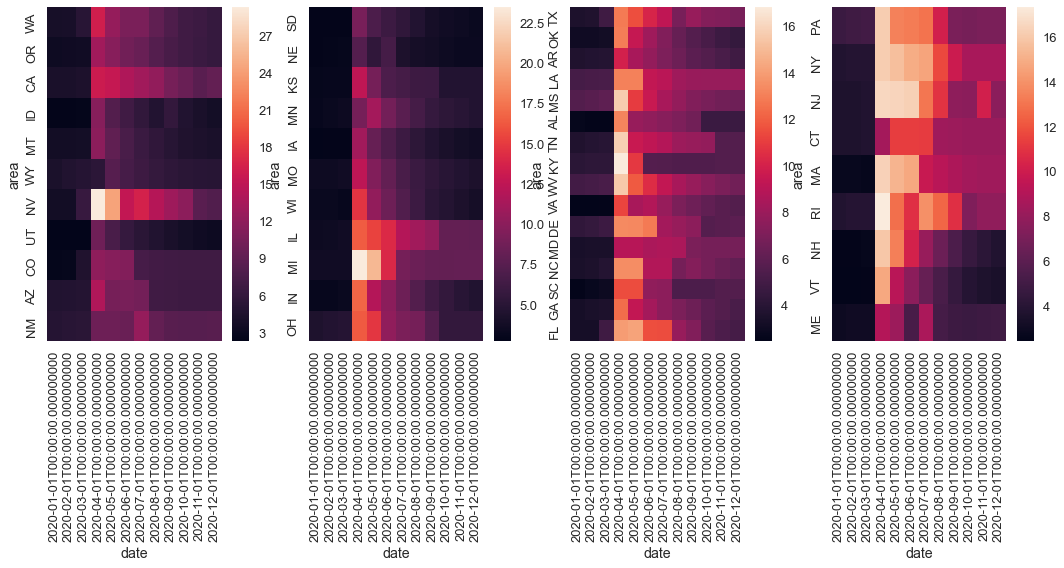

In [444]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,6))

sns.heatmap(intra_west_ur.T, ax=ax1)
sns.heatmap(intra_mid_ur.T, ax=ax2)
sns.heatmap(intra_south_ur.T, ax=ax3)
sns.heatmap(intra_north_ur.T, ax=ax4)

plt.show()

(-14205996.319552857, -7131248.786754098, 2620945.8783998117, 6483447.28674047)

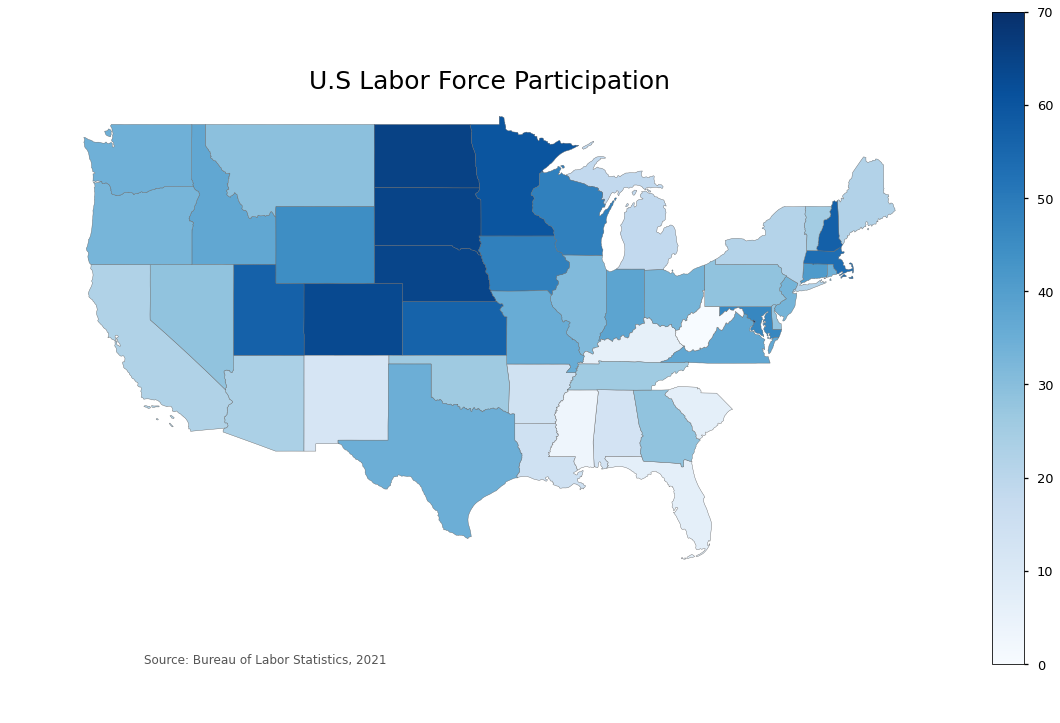

In [223]:
import geopandas as gp
import geoplot as gplt

# read in states shape file 
states = gp.read_file(r'C:\Users\alexa\CSS_Data Skills_Fall 2021\ferrante_moreira_data_project\Data\data\usa-states-census-2014.shp')
#set to be aligned with google maps
states = states.to_crs("EPSG:3395")
# rename states to area for mergeing
states = states.rename(columns={"NAME":"area"})

states["area"] = states["area"].replace(us_state_to_abbrev)

ex1 = df_lfp_small.query("date == '2021-01-01'").drop_duplicates(subset=["area"])

states_full = states.merge(ex1, on="area", how="right").drop_duplicates(subset=["area"]).dropna()
states_full["labor_force_participation"] = states_full["labor_force_participation"].astype(float)

fig, ax = plt.subplots(1, 1, figsize=(20, 12))

states_full.plot(column="labor_force_participation", cmap="Blues", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Blues", norm=plt.Normalize(vmin=0, vmax=70))
bar_info._A = []
cbar = fig.colorbar(bar_info)

ax.set_title("U.S Labor Force Participation", 
    fontdict={"fontsize":"25", "fontweight": "3"})
ax.annotate("Source: Bureau of Labor Statistics, 2021",xy=(0.1, .08),  
    xycoords="figure fraction", horizontalalignment="left", 
    verticalalignment="top", fontsize=12, color="#555555")

ax.axis("off")